In [25]:
import pandas as pd 
import numpy as np
import missingno as miss
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
import joblib
from xgboost.callback import EarlyStopping
from sklearn.metrics import mean_squared_error

In [26]:
data = pd.read_csv('train.csv')

In [3]:
data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


<Axes: >

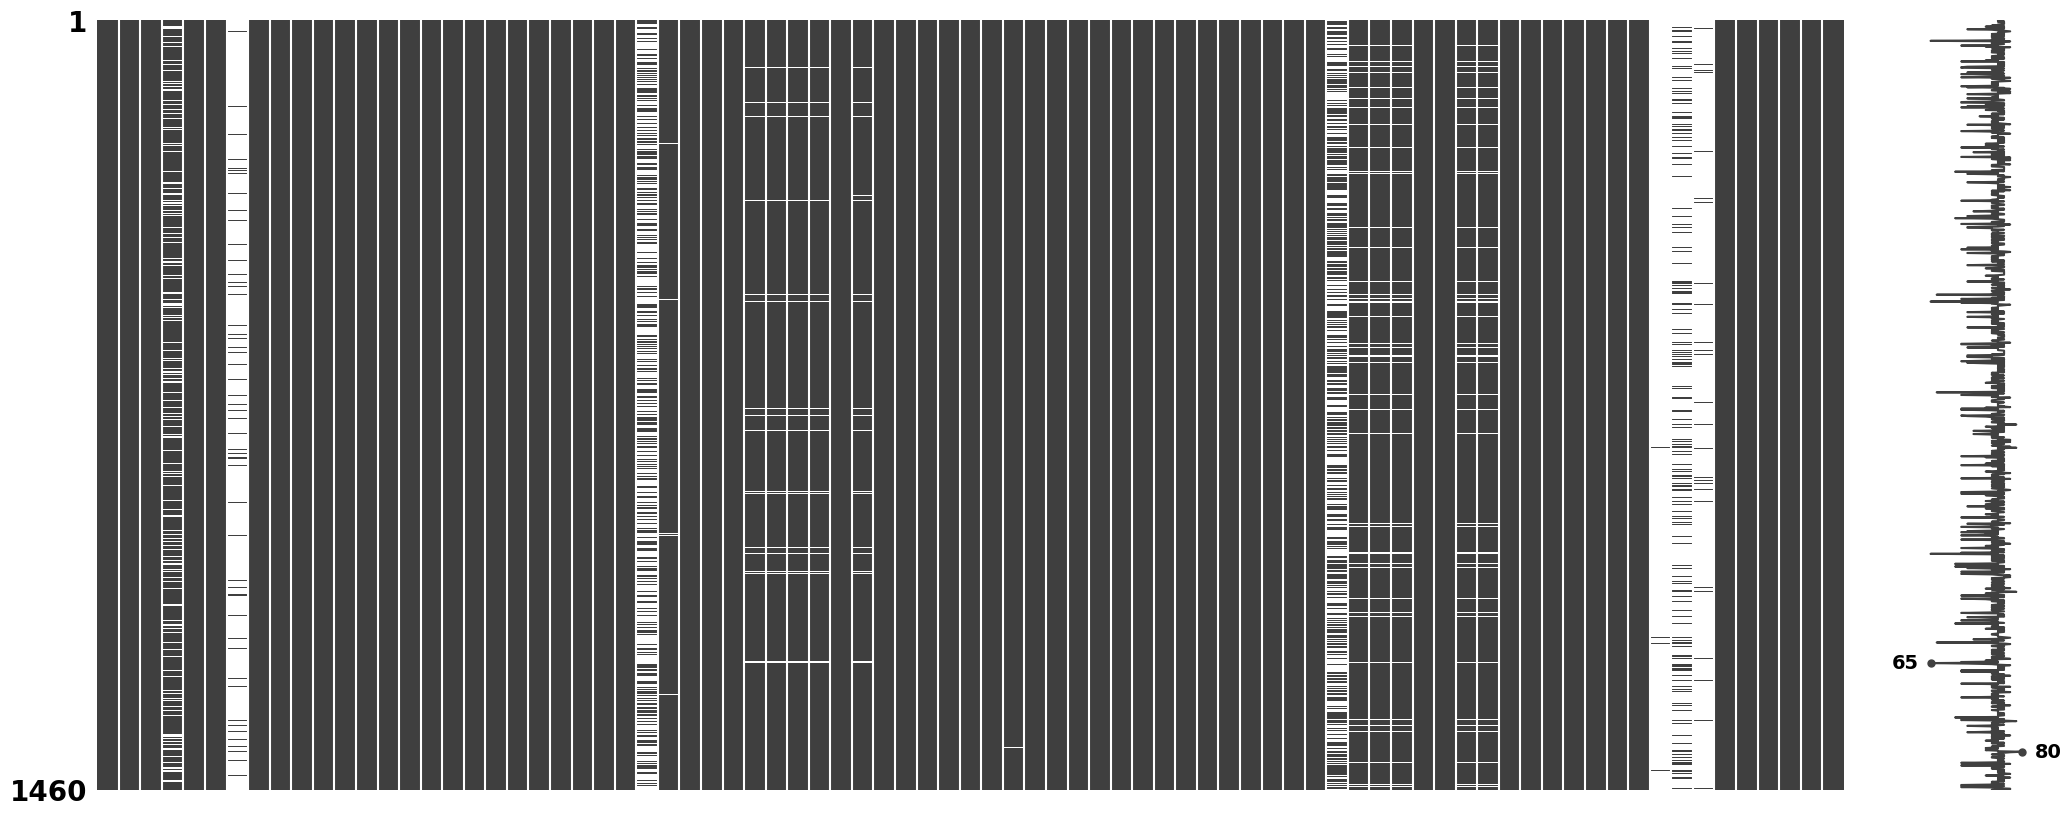

In [4]:
miss.matrix(data)

In [5]:
class DropMissingData(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.45):
        self. threshold = threshold
        self.columns_to_drop = []
        
        
    def fit(self, X, y=None):
        self.columns_to_drop = data.isnull().mean()[data.isnull().mean()>self.threshold].index.tolist()
        return self
    
    def transform(self, X):
        X= X.drop(columns = self.columns_to_drop, errors='ignore')
        
        X=X.dropna()
        return X

In [6]:
class CategoricalEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoders=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        self.cat = []
        
    def fit(self, X,y=None):
        X = X.copy()
        self.cat =  X.select_dtypes(include='object').columns
        self.encoders.fit(X[self.cat])
        return self
        
    def transform(self, X):
        X=X.copy()
        X[self.cat] = self.encoders.transform(X[self.cat])
        return X


In [7]:
class selectsignificant(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.05):
        self.alpha = alpha
        self.selected_features = []
        
    def fit(self,X,y):
        f_scores, p_values =f_regression(X, y)
        self.selected_features = X.columns[p_values<self.alpha].tolist()
        return self
    
    def transform(self,X):
        return X[self.selected_features]


In [8]:
class VIFCorrelationReducer(BaseEstimator, TransformerMixin):
    def __init__(self, corr_threshold=0.8, protected_columns=None):
        self.corr_threshold = corr_threshold
        self.protected_columns = protected_columns or []
        self.kept_features = []

    def fit(self, X, y=None):
        X = X.copy()
        self.kept_features = list(X.columns)

        while True:
            # Step 1: Correlation matrix
            corr_matrix = X.corr().abs()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

            # Step 2: Identify correlated pairs
            to_consider = [
                (row, col)
                for col in upper.columns
                for row in upper.index
                if upper.loc[row, col] >= self.corr_threshold
                and row not in self.protected_columns
                and col not in self.protected_columns
            ]

            if not to_consider:
                break

            # Step 3: Compute VIFs
            vif = pd.Series(
                [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
                index=X.columns
            )

            # Step 4: Drop one feature from each correlated pair based on higher VIF
            dropped = set()
            for f1, f2 in to_consider:
                if f1 in dropped or f2 in dropped:
                    continue  # skip if already dropped

                vif1 = vif.get(f1, np.inf)
                vif2 = vif.get(f2, np.inf)

                if vif1 > vif2:
                    drop = f1
                else:
                    drop = f2

                X = X.drop(columns=[drop])
                dropped.add(drop)

            # Step 5: Update list of features to keep
            self.features_to_keep = list(X.columns)

        return self

    def transform(self, X):
        return X[self.features_to_keep]

In [9]:
preprocessing = Pipeline([
    ('Categorical_encoding', CategoricalEncoding()),
    ('significant_selector',selectsignificant(alpha=0.05)),
    ('feature_selection',VIFCorrelationReducer(corr_threshold=0.8, protected_columns=['YearBuilt', 'YearRemodAdd','GarageYrBlt'])) 
    
])

In [10]:
def extraction(path):
    return pd.read_csv(path)

In [11]:

def preprocessing_data(data,target):
    missing_handler = DropMissingData(threshold=0.45)
    cleaned = missing_handler.fit_transform(data)
    Xclean = cleaned.drop(columns=target)
    y = cleaned[target]
    y_log = np.log(y)
    df_cleaned = preprocessing.fit_transform(Xclean,y_log)
    
    saved_columns = df_cleaned.columns if isinstance(df_cleaned, pd.DataFrame) else preprocessing.named_steps['feature_selection'].features_to_keep
    joblib.dump(saved_columns, 'saved_columns.pkl')
    joblib.dump(missing_handler, 'missing_handler.pkl')
    return df_cleaned,y_log, preprocessing

In [12]:
def data_split(X,y, test_size=0.2, val_size=0.4, random_state=42):
    xtrain,xtemp,ytrain,ytemp = train_test_split(X, y,test_size=test_size, random_state=random_state)
    xval,xtest,yval,ytest = train_test_split(xtemp,ytemp, test_size=val_size, random_state=random_state)
    return xtrain, xval,xtest,ytrain,yval,ytest

In [13]:
def training(xtrain, xval,ytrain,yval):
    model = XGBRegressor(
        objective='reg:squarederror',
        subsample= 0.8, 
        reg_lambda= 10, 
        reg_alpha= 0, 
        n_estimators= 500, 
        max_depth= 6, 
        learning_rate= 0.05, 
        colsample_bytree= 0.6
    )
    
    model.fit(
        xtrain, ytrain
    )
    joblib.dump(model, 'model.pkl')
    return model

In [14]:
def pipeline(path , target):
    raw = extraction(path)
    
    df_cleaned,y, preprocessor = preprocessing_data(raw,target)
    
    
    xtrain, xval,xtest,ytrain,yval,ytest = data_split(df_cleaned,y) 
    
    model = training(xtrain,xval,ytrain,yval)
    
    full_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    joblib.dump(full_pipe, 'full_pipeline.pkl')
    return full_pipe,df_cleaned,y,xtest,ytest

In [15]:
p,df,y,a,b = pipeline('train.csv', 'SalePrice')

In [16]:
columns = joblib.load('saved_columns.pkl').to_list()

In [17]:
datan = pd.read_csv('train.csv')

In [18]:
datac  = datan[columns]

In [19]:
datac['SalePrice'] = datan['SalePrice']

C:\Users\sehal\AppData\Local\Temp\ipykernel_40308\443884348.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datac['SalePrice'] = datan['SalePrice']


In [20]:
datac['YrSold']= datan['YrSold']

C:\Users\sehal\AppData\Local\Temp\ipykernel_40308\984989839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datac['YrSold']= datan['YrSold']


In [21]:
datac = datac.dropna()

In [22]:
datac

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LotConfig,Neighborhood,Condition1,HouseStyle,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,MoSold,SaleCondition,SalePrice,YrSold
0,60,RL,65.0,8450,Pave,Reg,Inside,CollgCr,Norm,2Story,...,Y,0,61,0,0,0,2,Normal,208500,2008
1,20,RL,80.0,9600,Pave,Reg,FR2,Veenker,Feedr,1Story,...,Y,298,0,0,0,0,5,Normal,181500,2007
2,60,RL,68.0,11250,Pave,IR1,Inside,CollgCr,Norm,2Story,...,Y,0,42,0,0,0,9,Normal,223500,2008
3,70,RL,60.0,9550,Pave,IR1,Corner,Crawfor,Norm,2Story,...,Y,0,35,272,0,0,2,Abnorml,140000,2006
4,60,RL,84.0,14260,Pave,IR1,FR2,NoRidge,Norm,2Story,...,Y,192,84,0,0,0,12,Normal,250000,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Inside,Gilbert,Norm,2Story,...,Y,0,40,0,0,0,8,Normal,175000,2007
1456,20,RL,85.0,13175,Pave,Reg,Inside,NWAmes,Norm,1Story,...,Y,349,0,0,0,0,2,Normal,210000,2010
1457,70,RL,66.0,9042,Pave,Reg,Inside,Crawfor,Norm,2Story,...,Y,0,60,0,0,0,5,Normal,266500,2010
1458,20,RL,68.0,9717,Pave,Reg,Inside,NAmes,Norm,1Story,...,Y,366,0,112,0,0,4,Normal,142125,2010


In [24]:
datac.to_csv('df_cleaned.csv', index=False)

In [27]:
columns = joblib.load('saved_columns.pkl').tolist()